# Uncertainty Quantification

In this notebook we consider two sources of uncertainty:

- Uncertainty stemming from the different way we split the dataset into training-validation-test sets.

- Uncertainties due to label noise (mislabeling)


### Import packages

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import random

# Colab in order to download files
from google.colab import files

# =========================================
# =========================================
# scikit-learn for Machine Learn

# Preprocessing
from sklearn.preprocessing import StandardScaler #Standar scaler for standardization
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
from sklearn.model_selection import train_test_split #Train test split
# Classifiers
from sklearn.svm import SVC #Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier as RF #Random Forests
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Balanced metrics
from sklearn.metrics import balanced_accuracy_score


# =======================================
# =======================================
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## Part I: Different random seeds

We consider 6 different random seeds


**Import dataset**

In [2]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The LSBG image dataset
LSBG_data_1 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_1.npy"))/255.
LSBG_data_2 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_2.npy"))/255.
LSBG_data_3 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_3.npy"))/255.
LSBG_data_4 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/LSBG_sample_4.npy"))/255.
# ===============================================================================================
# ===============================================================================================
# The artefacts image dataset
Negative_data_2_1 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_1.npy"))/255.
Negative_data_2_2 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_2.npy"))/255.
Negative_data_2_3 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_3.npy"))/255.
Negative_data_2_4 = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Negative_sample_2_4.npy"))/255.
# ===============================================================================================
# ===============================================================================================
# Import the HSC dataset - positives and negatives
HSC_data = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Greco_sample_good.npy"))/255.
HSC_negatives = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/Greco_sample_junk.npy"))/255.

Combine LSBG and artefacts data into one dataset

In [4]:
X_mat = np.concatenate((LSBG_data_1,LSBG_data_2,LSBG_data_3,LSBG_data_4,
                        Negative_data_2_1,Negative_data_2_2,Negative_data_2_3,Negative_data_2_4)) # Features matrix
# ==============================================================================
# ==============================================================================
y_label = np.concatenate((np.ones(20000),np.zeros(20000))) # Labels 

In [5]:
seeds = [1,3,18,33,42,96] #Random seeds
n_loops = 6 #Number of loops/random seeds


# ============================================
# Create empty arrays for the evaluation metrics of each loop

Accuracies = np.zeros(n_loops)
Precisions = np.zeros(n_loops)
Recalls = np.zeros(n_loops)
tprs = np.zeros((n_loops,200))
fprs = np.linspace(0,1,200)
AUCs = np.zeros(n_loops)

Calculate over loops

In [6]:
for i in range(n_loops):
  # Clear the backend session
  tf.keras.backend.clear_session()
  # ============================================================================
  # ============================================================================
  # Get local seed
  loc_seed = seeds[i]
  # Now split the DES dataset in training, validation and test sets
  # First in training and a set for validation and test 
  X_tr, X_valt, y_tr, y_valt = train_test_split(X_mat, y_label, test_size=0.25, random_state=loc_seed)
  # Now split in validation and test sets 
  X_val, X_test, y_val, y_test = train_test_split(X_valt, y_valt, test_size=0.50, random_state=loc_seed)
  # ============================================================================ 
  # ============================================================================
  # Now build the model
  model = keras.models.Sequential()
  model.add(InputLayer((64,64,3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adadelta(0.1),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  # ============================================================================
  # Now fit the model
  model.fit(x=X_tr, y=y_tr,
          epochs=100, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now predict on the test set
  y_pred = model.predict_classes(X_test)
  # Predict probability scores
  scores = model.predict(X_test)
  # ============================================================================
  # ============================================================================
  # Evaluation metrics 

  Accuracies[i] = accuracy_score(y_test, y_pred)
  Precisions[i] = precision_score(y_test, y_pred)
  Recalls[i] = recall_score(y_test, y_pred)
  AUCs[i] = roc_auc_score(y_test, scores[:,0])
  # ============================================================================
  # Get now false positives and true positives
  fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=1.0)
  fpr_unique, ind_unique = np.unique(fpr,return_index=True)
  tpr_unique = tpr[ind_unique]

  # Interpolate the false positives - true positives
  interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
  tprs[i,:] = interp(fprs)

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 62.0233 - accuracy: 0.8035 - val_loss: 7.8454 - val_accuracy: 0.6938
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 2.8132 - accuracy: 0.8732 - val_loss: 1.1885 - val_accuracy: 0.8110
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.7556 - accuracy: 0.8920 - val_loss: 0.6220 - val_accuracy: 0.8640
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4937 - accuracy: 0.9001 - val_loss: 0.4565 - val_accuracy: 0.8886
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4062 - accuracy: 0.9050 - val_loss: 0.3945 - val_accuracy: 0.8958
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3632 - accuracy: 0.9054 - val_loss: 0.3463 - val_accuracy: 0.9116
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3419 - accuracy: 0.9053 - val_loss: 0.3166 - val_accuracy: 0.907

**Print evaluation metrics**

In [7]:
print('Accuracies are:',Accuracies)
print('Precisions are:',Precisions)
print('Recalls are:',Recalls)
print('AUCs are:', AUCs)

Accuracies are: [0.9116 0.9148 0.917  0.9144 0.9198 0.915 ]
Precisions are: [0.86808957 0.87000726 0.88956127 0.89617908 0.92396497 0.89766194]
Recalls are: [0.97446976 0.9724026  0.95030303 0.93591294 0.91702884 0.9368    ]
AUCs are: [0.96670569 0.97138279 0.96837564 0.96762429 0.97234695 0.97126432]


### Import data in the original split

In [11]:
# For image-based classification
X_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train.npy")) #Training
X_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_val.npy")) #Validation
X_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test.npy")) #Test

# Labels
y_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train.npy")) # Training
y_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_val.npy")) #Validation
y_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test.npy")) #Test

In [12]:
# Clear the backend session

tf.keras.backend.clear_session()
# build the  original model
model = keras.models.Sequential()
model.add(InputLayer((64,64,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adadelta(0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [13]:
model.fit(x=X_tr, y=y_tr,
          epochs=100, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 60.2342 - accuracy: 0.8029 - val_loss: 7.7306 - val_accuracy: 0.8620
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 2.9623 - accuracy: 0.8705 - val_loss: 1.2512 - val_accuracy: 0.8216
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.7781 - accuracy: 0.8911 - val_loss: 0.6225 - val_accuracy: 0.8716
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4846 - accuracy: 0.8998 - val_loss: 0.4217 - val_accuracy: 0.9032
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3935 - accuracy: 0.9045 - val_loss: 0.3782 - val_accuracy: 0.9008
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3524 - accuracy: 0.9068 - val_loss: 0.3590 - val_accuracy: 0.8968
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3316 - accuracy: 0.9044 - val_loss: 0.3139 - val_accuracy: 0.910

Predict now and calculate ROC

In [14]:
# Predict classes
y_pred = model.predict_classes(X_test)
# Predict probability scores
scores = model.predict(X_test)

In [15]:
# fpr, tpr for roc curve plot
fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=1.0)

fpr_unique, ind_unique = np.unique(fpr,return_index=True)
tpr_unique = tpr[ind_unique]

# Interpolate the false positives - true positives
interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
tpr_baseline = interp(fprs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

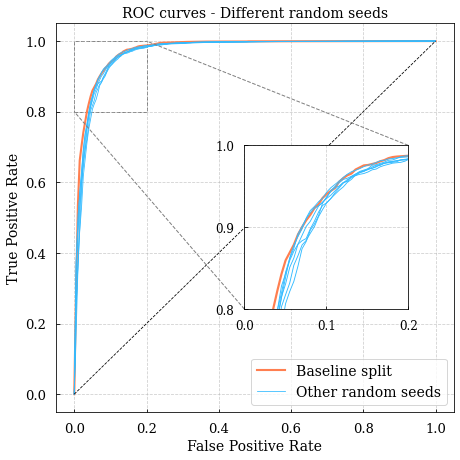

In [23]:
custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]

x = np.linspace(0,1,100)


fig, ax1 = plt.subplots(figsize = (6.5,6.5))
# =============================================================
# =============================================================
# Main figure

ax1.plot(fprs,tpr_baseline,c='coral',linewidth=2.1, label='Baseline split')
ax1.plot(fprs,tprs[0],c=custom_blues[1],linewidth=0.8)
ax1.plot(fprs,tprs[1],c=custom_blues[1],linewidth=0.8)
ax1.plot(fprs,tprs[2],c=custom_blues[1],linewidth=0.8,label='Other random seeds')
ax1.plot(fprs,tprs[3],c=custom_blues[1],linewidth=0.8)
ax1.plot(fprs,tprs[4],c=custom_blues[1],linewidth=0.8)
ax1.plot(fprs,tprs[5],c=custom_blues[1],linewidth=0.8)



#Plot diagonal
ax1.plot(x,x, c='k',ls='--',linewidth=0.8)
ax1.grid(ls='--', alpha=0.6)

ax1.set_xlabel('False Positive Rate',fontsize=14);ax1.set_ylabel('True Positive Rate',fontsize=14)
ax1.tick_params(axis='both', labelsize=13)


ax1.legend(frameon=True, loc='lower right', fontsize=14)
# =============================================================
# =============================================================
# Inset figure
left, bottom, width, height = [0.53, 0.33, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(fprs,tpr_baseline,c='coral',linewidth=2.2)
ax2.plot(fprs,tprs[0],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[1],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[2],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[3],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[4],c=custom_blues[1],linewidth=0.9)
ax2.plot(fprs,tprs[5],c=custom_blues[1],linewidth=0.9)


ax2.set_xlim(0.0,0.2)
ax2.set_ylim(0.8,1.0)
ax2.set_xticks([0.0,0.1,0.2])
ax2.set_yticks([0.8,0.9,1.0])
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(ls='--', alpha=0.6)
# =============================================================
# =============================================================
# Format the whole figure
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none",ls='--', ec='0.5')
ax1.set_title('ROC curves - Different random seeds',fontsize=14)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/ROC_other_seeds.pdf")
#files.download("/content/drive/My Drive/Plots/ROC_other_seeds.pdf")
plt.show()

## Part II: Effect of label noise

**In this part we explore the effect of the label noise.**

The training set has 30000 labeled examples. To estimate the effect of label noise (random mislabeling) we randomly change the labels of i) $1\%$, ii) $5\%$ and iii) $10\%$ iv) $1/3$ of the total sample. (In number of examples, then these number correspond to 300, 1500, 3000 and 10000 examples, respectively).


### IIa) Random noise

In this case the noise does not have any preference, so when the initial label is 0 it becomes 1, while when the initial lable is 1 it becomes 0.

In [24]:
# Create empty arrays for the evaluation metrics of each loop
Accuracies_noise = np.zeros(4)
Precisions_noise = np.zeros(4)
Recalls_noise = np.zeros(4)
tprs_noise = np.zeros((4,200))
fprs_noise = np.linspace(0,1,200)
AUCs_noise = np.zeros(4)

# =====================================================
num_examples = [300,1500,3000,10000] #Number of examples to change the labels

In [25]:
for i in range(4):
  # Clear the backend session
  tf.keras.backend.clear_session()
  # ============================================================================
  # ============================================================================
  # Number of examples to change the labels
  n_examples = num_examples[i]
  
  #Get n_examples random indices from 0 to 30000
  rands_loc = random.sample(range(0, 30000),n_examples)

  y_train_loc = np.copy(y_tr) #Make a copy of y_train 
  # Change the indices 
  y_train_loc[rands_loc] = y_train_loc[rands_loc] + 1 
  y_train_loc[y_train_loc>1] = 0

  # ============================================================================
  # ============================================================================ 
  # ============================================================================
  # Now build the model
  model = keras.models.Sequential()
  model.add(InputLayer((64,64,3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adadelta(0.1),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  # ============================================================================
  # Now fit the model
  model.fit(x=X_tr, y=y_train_loc,
          epochs=100, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now predict on the test set
  y_pred_loc = model.predict_classes(X_test)
  # Predict probability scores
  scores_loc = model.predict(X_test)
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Evaluation metrics 

  Accuracies_noise[i] = accuracy_score(y_test, y_pred_loc)
  Precisions_noise[i] = precision_score(y_test, y_pred_loc)
  Recalls_noise[i] = recall_score(y_test, y_pred_loc)
  AUCs_noise[i] = roc_auc_score(y_test, scores_loc[:,0])
  # ============================================================================
  # Get now false positives and true positives
  fpr, tpr, thresholds = roc_curve(y_test, scores_loc[:,0], pos_label=1.0)
  fpr_unique, ind_unique = np.unique(fpr,return_index=True)
  tpr_unique = tpr[ind_unique]

  # Interpolate the false positives - true positives
  interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
  tprs_noise[i,:] = interp(fprs_noise)

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 57.9916 - accuracy: 0.7981 - val_loss: 6.9900 - val_accuracy: 0.6750
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 2.6419 - accuracy: 0.8638 - val_loss: 1.1316 - val_accuracy: 0.8136
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.7313 - accuracy: 0.8819 - val_loss: 0.5717 - val_accuracy: 0.8746
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4893 - accuracy: 0.8905 - val_loss: 0.4347 - val_accuracy: 0.8898
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4153 - accuracy: 0.8935 - val_loss: 0.3893 - val_accuracy: 0.8886
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3782 - accuracy: 0.8960 - val_loss: 0.3527 - val_accuracy: 0.9108
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3573 - accuracy: 0.8989 - val_loss: 0.3228 - val_accuracy: 0.903

In [26]:
print(Accuracies_noise)
print(Precisions_noise)
print(Recalls_noise)
print(AUCs_noise)

[0.9184 0.9142 0.9088 0.883 ]
[0.89947683 0.89988666 0.92171106 0.87989151]
[0.94540456 0.93558523 0.89709348 0.89198743]
[0.97451617 0.9700637  0.96984867 0.95018978]


### IIb) Biased noise

**Part I**

In this part we assume a systematic mislabeling of LSBGs as artefacts 1 $\to$ 0. This is something that can happen if we are too conservative, favoring purity over completeness in our visual inspection of the training set.


We randomly select 300, 1500 and 3000 LSBGs and we change their labels

In [ ]:
# Create empty arrays for the evaluation metrics of each loop
Accuracies_biasedLSBG = np.zeros(3)
Accuracies_balanced_biasedLSBG = np.zeros(3)
Precisions_biasedLSBG = np.zeros(3)
Recalls_biasedLSBG = np.zeros(3)
tprs_biasedLSBG = np.zeros((3,200))
fprs_biasedLSBG = np.linspace(0,1,200)
AUCs_biasedLSBG = np.zeros(3)
# =================================
# =================================
num_examples = [300,1500,3000] #Number of examples to change the labels

In [ ]:
for i in range(3):
  # Clear the backend session
  tf.keras.backend.clear_session()
  # ============================================================================
  # ============================================================================
  # Number of examples to change the labels
  n_examples = num_examples[i]

  # Make now a copy of y_train
  y_train_loc = np.copy(y_tr)

  # Now get an array with the indices in the y_train array that 
  # point to the elements with y_train = 1 (LSBGs) 
  indices_LSBG = np.asarray(np.where(y_train_loc==1.0)[0])

  # Now get n_examples random indices from 0 to len(indices_LSBG)
  rands_loc = random.sample(range(0, len(indices_LSBG)),n_examples)

  # Now get indices of the objects to change
  indices_change = indices_LSBG[rands_loc]

  # Now, change the indices 
  y_train_loc[indices_change] = 0.
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now build the model
  model = keras.models.Sequential()
  model.add(InputLayer((64,64,3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adadelta(0.1),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  # ============================================================================
  # Now fit the model
  model.fit(x=X_tr, y=y_train_loc,
          epochs=20, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now predict on the test set
  y_pred_loc = model.predict_classes(X_test)
  # Predict probability scores
  scores_loc = model.predict(X_test)
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Evaluation metrics 

  Accuracies_biasedLSBG[i] = accuracy_score(y_test, y_pred_loc)
  Accuracies_balanced_biasedLSBG[i] = balanced_accuracy_score(y_test, y_pred_loc)
  Precisions_biasedLSBG[i] = precision_score(y_test, y_pred_loc)
  Recalls_biasedLSBG[i] = recall_score(y_test, y_pred_loc)
  AUCs_biasedLSBG[i] = roc_auc_score(y_test, scores_loc[:,0])
  # ============================================================================
  # Get now false positives and true positives
  fpr, tpr, thresholds = roc_curve(y_test, scores_loc[:,0], pos_label=1.0)
  fpr_unique, ind_unique = np.unique(fpr,return_index=True)
  tpr_unique = tpr[ind_unique]

  # Interpolate the false positives - true positives
  interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
  tprs_biasedLSBG[i,:] = interp(fprs_biasedLSBG)

Epoch 1/20
469/469 [==============================] - 3s 7ms/step - loss: 58.2149 - accuracy: 0.8024 - val_loss: 7.0462 - val_accuracy: 0.6448
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 2.6662 - accuracy: 0.8644 - val_loss: 1.1531 - val_accuracy: 0.8298
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.7424 - accuracy: 0.8814 - val_loss: 0.6134 - val_accuracy: 0.8562
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4879 - accuracy: 0.8910 - val_loss: 0.4845 - val_accuracy: 0.8698
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4125 - accuracy: 0.8952 - val_loss: 0.3812 - val_accuracy: 0.8952
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3770 - accuracy: 0.8971 - val_loss: 0.3381 - val_accuracy: 0.9028
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3551 - accuracy: 0.8994 - val_loss: 0.3281 - val_accuracy: 0.9018
Epoch

In [ ]:
print(Accuracies_biasedLSBG)
print(Accuracies_balanced_biasedLSBG)
print(Precisions_biasedLSBG)
print(Recalls_biasedLSBG)
print(AUCs_biasedLSBG)

[0.9102 0.9152 0.9154]
[0.90903944 0.91433196 0.91453571]
[0.86750789 0.88248017 0.88279841]
[0.97211312 0.96150825 0.96150825]
[0.9705666  0.97082476 0.96821348]


**Part II**

In this part we assume a systematic mislabeling of artefacts as LSBGs 0 $\to$ 1. This is something that can happen if we are too conservative, favoring purity over completeness in our visual inspection of the training set.


We randomly select 300, 1500 and 3000 artefacts and we change their labels

In [ ]:
# Create empty arrays for the evaluation metrics of each loop
Accuracies_biasedArtefacts = np.zeros(3)
Accuracies_balanced_biasedArtefacts = np.zeros(3)
Precisions_biasedArtefacts = np.zeros(3)
Recalls_biasedArtefacts = np.zeros(3)
tprs_biasedArtefacts = np.zeros((3,200))
fprs_biasedArtefacts = np.linspace(0,1,200)
AUCs_biasedArtefacts = np.zeros(3)
# =================================
# =================================
num_examples = [300,1500,3000] #Number of examples to change the labels

In [ ]:
for i in range(3):
  # Clear the backend session
  tf.keras.backend.clear_session()
  # ============================================================================
  # ============================================================================
  # Number of examples to change the labels
  n_examples = num_examples[i]

  # Make now a copy of y_train
  y_train_loc = np.copy(y_tr)

  # Now get an array with the indices in the y_train array that 
  # point to the elements with y_train = 1 (LSBGs) 
  indices_LSBG = np.asarray(np.where(y_train_loc==0.0)[0])

  # Now get n_examples random indices from 0 to len(indices_LSBG)
  rands_loc = random.sample(range(0, len(indices_LSBG)),n_examples)

  # Now get indices of the objects to change
  indices_change = indices_LSBG[rands_loc]

  # Now, change the indices 
  y_train_loc[indices_change] = 1.
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now build the model
  model = keras.models.Sequential()
  model.add(InputLayer((64,64,3)))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adadelta(0.1),
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  # ============================================================================
  # Now fit the model
  model.fit(x=X_tr, y=y_train_loc,
          epochs=20, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Now predict on the test set
  y_pred_loc = model.predict_classes(X_test)
  # Predict probability scores
  scores_loc = model.predict(X_test)
  # ============================================================================
  # ============================================================================
  # ============================================================================
  # Evaluation metrics 

  Accuracies_biasedArtefacts[i] = accuracy_score(y_test, y_pred_loc)
  Accuracies_balanced_biasedArtefacts[i] = balanced_accuracy_score(y_test, y_pred_loc)
  Precisions_biasedArtefacts[i] = precision_score(y_test, y_pred_loc)
  Recalls_biasedArtefacts[i] = recall_score(y_test, y_pred_loc)
  AUCs_biasedArtefacts[i] = roc_auc_score(y_test, scores_loc[:,0])
  # ============================================================================
  # Get now false positives and true positives
  fpr, tpr, thresholds = roc_curve(y_test, scores_loc[:,0], pos_label=1.0)
  fpr_unique, ind_unique = np.unique(fpr,return_index=True)
  tpr_unique = tpr[ind_unique]

  # Interpolate the false positives - true positives
  interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
  tprs_biasedArtefacts[i,:] = interp(fprs_biasedLSBG)

Epoch 1/20
469/469 [==============================] - 3s 7ms/step - loss: 56.5264 - accuracy: 0.7977 - val_loss: 6.6501 - val_accuracy: 0.6608
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 2.5578 - accuracy: 0.8656 - val_loss: 1.0837 - val_accuracy: 0.8638
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.7308 - accuracy: 0.8827 - val_loss: 0.5806 - val_accuracy: 0.8654
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4846 - accuracy: 0.8909 - val_loss: 0.4368 - val_accuracy: 0.8916
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4098 - accuracy: 0.8947 - val_loss: 0.3713 - val_accuracy: 0.9024
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3753 - accuracy: 0.8973 - val_loss: 0.3411 - val_accuracy: 0.9012
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3562 - accuracy: 0.8994 - val_loss: 0.3386 - val_accuracy: 0.8978
Epoch

In [ ]:
print(Accuracies_biasedArtefacts)
print(Accuracies_balanced_biasedArtefacts)
print(Precisions_biasedArtefacts)
print(Recalls_biasedArtefacts)
print(AUCs_biasedArtefacts)

[0.9158 0.9094 0.8922]
[0.91523034 0.90815819 0.89056215]
[0.8945414 0.864     0.836632 ]
[0.9461901  0.97564808 0.97957581]
[0.97113767 0.9697424  0.96984619]


### Make a ROC curve

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


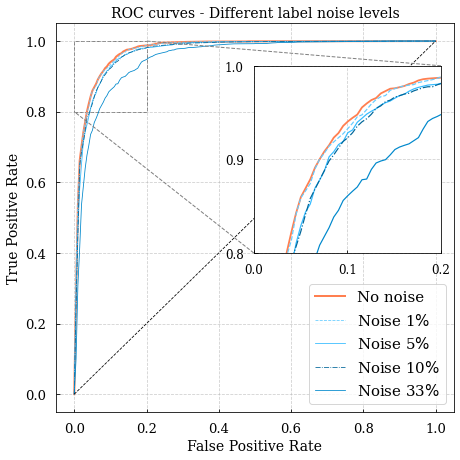

In [45]:
custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]

x = np.linspace(0,1,100)
# ==================================================================
# ==================================================================
fig, ax1 = plt.subplots(figsize = (6.5,6.5))
# =============================================================
# =============================================================
# Main figure

ax1.plot(fprs,tpr_baseline,c='coral',linewidth=2.0, label='No noise')
ax1.plot(fprs_noise,tprs_noise[0],c=custom_blues[0],ls='--',linewidth=0.8, label='Noise 1$\%$')
ax1.plot(fprs_noise,tprs_noise[1],c=custom_blues[1],linewidth=0.8, label='Noise 5$\%$')
ax1.plot(fprs_noise,tprs_noise[2],c=custom_blues[4],ls='-.',linewidth=0.8, label='Noise 10$\%$')
ax1.plot(fprs_noise,tprs_noise[3],c=custom_blues[3],linewidth=0.8, label='Noise 33$\%$')


#Plot diagonal
ax1.plot(x,x, c='k',ls='--',linewidth=0.8)
ax1.grid(ls='--', alpha=0.6)

ax1.set_xlabel('False Positive Rate',fontsize=14);ax1.set_ylabel('True Positive Rate',fontsize=14)
ax1.tick_params(axis='both', labelsize=13)


ax1.legend(frameon=True, loc='lower right', fontsize=15)
# =============================================================
# =============================================================
# Inset figure
left, bottom, width, height = [0.55, 0.45, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(fprs,tpr_baseline,c='coral',linewidth=1.8)
ax2.plot(fprs_noise,tprs_noise[0],c=custom_blues[0],ls='--',linewidth=1.2)
ax2.plot(fprs_noise,tprs_noise[1],c=custom_blues[1],linewidth=1.2)
ax2.plot(fprs_noise,tprs_noise[2],c=custom_blues[4],ls='-.',linewidth=1.2)
ax2.plot(fprs_noise,tprs_noise[3],c=custom_blues[3],linewidth=1.2)



ax2.set_xlim(0.00,0.2)
ax2.set_ylim(0.8,1.00)
ax2.set_xticks([0.0,0.1,0.2])
ax2.set_yticks([0.8,0.9,1.0])
ax2.tick_params(axis='both', labelsize=12)
ax2.grid(ls='--', alpha=0.6)
# =============================================================
# =============================================================
# Format the whole figure
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none",ls='--', ec='0.5')
ax1.set_title('ROC curves - Different label noise levels',fontsize=14)



# ==================================================================
# ==================================================================
plt.tight_layout()

plt.savefig("/content/drive/My Drive/Plots/ROC_noisy.pdf")
#files.download("/content/drive/My Drive/Plots/ROC_noisy.pdf")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

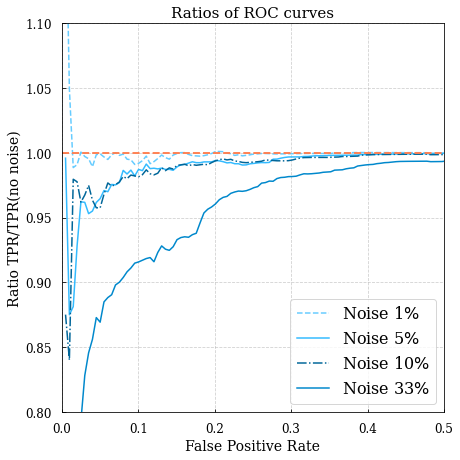

In [74]:
x = np.linspace(0.0,0.5,100)
y_loc = np.ones(100)
plt.figure(figsize = (6.5,6.5))


plt.plot(fprs_noise,tprs_noise[0]/tpr_baseline,c=custom_blues[0],ls='--',linewidth=1.5,label='Noise 1$\%$')
plt.plot(fprs_noise,tprs_noise[1]/tpr_baseline,c=custom_blues[1],linewidth=1.5,label='Noise 5$\%$')
plt.plot(fprs_noise,tprs_noise[2]/tpr_baseline,c=custom_blues[4],ls='-.',linewidth=1.5,label='Noise 10$\%$')
plt.plot(fprs_noise,tprs_noise[3]/tpr_baseline,c=custom_blues[3],linewidth=1.5,label='Noise 33$\%$')

plt.plot(x,y_loc,c='coral',ls='--',linewidth=1.9)

plt.xlim(0,0.5)
plt.ylim(0.8,1.1)

plt.tick_params(axis='both', labelsize=12)
plt.grid(ls='--', alpha=0.6)

plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('Ratio TPR/TPR(no noise)', fontsize=14)
plt.legend(frameon=True, loc='lower right', fontsize=16)


plt.title('Ratios of ROC curves', fontsize=15)
plt.tight_layout()

plt.savefig("/content/drive/My Drive/Plots/ROC_ratios.pdf")
#files.download("/content/drive/My Drive/Plots/ROC_ratios.pdf")
plt.show()